# Optimise pruning parameters

This Notebook shows how to optimise the pruning parameters of your network based on pairwise connectivity data.

First we need to create a small network that we can use for the optimisation of the pruning parameters.

In this example we do not need to have realistic neuron densities, so we will place the neurons in a cube of diameter 150 micrometers.

In [1]:
import os
import numpy as np

n_neurons = 300

pop_size = 15
# epochs = 10

pre_type = "iSPN"     # "iSPN"
post_type = "iSPN"  # "iSPN"
con_type = "GABA"

avg_num_synapses_per_pair = 3  # Expected mean, error weight

# param_names = ["f1", "softMax", "mu2", "a3"]
param_names = ["f1", "mu2", "a3"]

distance_dependent_pruning = True

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
FS_dist_dep_pruning = "exp(-(0.5*d/60e-6)**2)" 
LTS_dist_dep_pruning = "1-exp(-(0.4*d/60e-6)**2)"


extra_pruning_parameters = { }

if distance_dependent_pruning:
    if pre_type == "FS" and (post_type == "dSPN" or post_type == "iSPN"):
        extra_pruning_parameters = { 'distPruning': FS_dist_dep_pruning }
    elif "SPN" in pre_type and "SPN" in post_type:
        extra_pruning_parameters = { 'distPruning': SPN2SPNdistDepPruning }
    elif "LTS" in pre_type and "SPN" in post_type:
        extra_pruning_parameters = { 'distPruning': LTS_dist_dep_pruning }
    else:
        # No distance dependent pruning available for this neuron type, set it to False
        distance_dependent_pruning = False
        
dd_str = "_distdep" if distance_dependent_pruning else ""
par_str = "_".join(param_names) + dd_str
network_path = os.path.join("networks", f"{pre_type}_to_{post_type}_{par_str}")

        
all_experimental_data = {}
all_experimental_data["dSPN", "iSPN"] = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
all_experimental_data["dSPN", "dSPN"] = [(0, 50e-6, 5/19.0), (0, 100e-6, 3/43.0)]
all_experimental_data["iSPN", "iSPN"] = [(0, 50e-6, 14/39.0), (0, 100e-6, 7/31.0)]
all_experimental_data["iSPN", "dSPN"] = [(0, 50e-6, 13/47.0), (0, 100e-6, 10/80.0)]

all_experimental_data["FS", "FS"] = [(0, 250e-6, 7/12.0)]
all_experimental_data["FS", "iSPN"] = [(0, 100e-6, 6/9.0), (0, 150e-6, 21/54.0), (0, 250e-6, 27/77.0)]
all_experimental_data["FS", "dSPN"] = [(0, 100e-6, 8/9.0), (0, 150e-6, 29/48.0), (0, 250e-6, 48/90.0)]
all_experimental_data["FS", "LTS"] = [(0, 250e-6, 2/12.0)]

all_experimental_data["LTS", "dSPN"] = [(0, 250e-6, 2/60.0)]
all_experimental_data["LTS", "iSPN"] = [(0, 250e-6, 2/60.0)]

all_experimental_data["ChIN", "dSPN"] = [(0, 250e-6, 0.05)]
all_experimental_data["ChIN", "iSPN"] = [(0, 250e-6, 0.05)]


experimental_data = all_experimental_data[pre_type, post_type]

cube_side = np.max([max(x[1], 250e-6) for x in experimental_data])

axon_cloud = dict()
LTS_density_str = ("12*3000*1e12*( 0.25*exp(-(((x-200e-6)/100e-6)**2 "
                           "+ ((y-0)/50e-6)**2 + ((z-0)/30e-6)**2)) "
                           "+ 1*exp(-(((x-300e-6)/300e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/10e-6)**2)) "
                           "+ 1*exp(-(((x-700e-6)/100e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/15e-6)**2)) )")

axon_cloud["LTS"] = ("xyz", LTS_density_str, [-200e-6, 900e-6, -100e-6, 100e-6, -30e-6, 30e-6])
axon_cloud["CHIN"] = ("r", "5000*1e12/3*exp(-r/120e-6)", 350e-6)

In [2]:
from snudda.place.create_cube_mesh import create_cube_mesh

mesh_file = os.path.join(network_path, "cube-mesh.obj")
create_cube_mesh(mesh_file, [0,0,0], cube_side)

from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123, snudda_data="../../../../../BasalGangliaData/data/")

si.define_structure(struct_name="Cube", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)

if pre_type in axon_cloud:
    pre_ac = axon_cloud[pre_type]
else:
    pre_ac = None
    
if post_type in axon_cloud:
    post_ac = axon_cloud[post_type]
else:
    post_ac = None

if pre_type == post_type:
    
    si.add_neurons(name=pre_type, num_neurons=n_neurons, volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum",pre_type.lower()))
else:
    si.add_neurons(name=pre_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", pre_type.lower()))
    si.add_neurons(name=post_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=post_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", post_type.lower()))
    

# The parameters here does not matter, they will be set during optimisation
si.add_neuron_target(neuron_name=pre_type,
                     target_name=post_type,
                     region_name="Cube",
                     connection_type=con_type,
                     dist_pruning=None,
                     f1=None, soft_max=None, mu2=None,
                     a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     mod_file="tmGabaA")

si.write_json()

Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
Writing networks/iSPN_to_iSPN_f1_mu2_a3_distdep/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/iSPN_to_iSPN_f1_mu2_a3_distdep/network-config.json
No n_putative_points and putative_density, setting n_putative_points = 6172
(this must be larger than the number of neurons you want to place)
Generating 6172 points for networks/iSPN_to_iSPN_f1_mu2_a3_distdep/cube-mesh.obj
Filtering, keeping inside points: 2413 / 3257
neuron_name = 'iSPN_0', num = np.int64(75), neuron_path = '$SNUDDA_DATA/neurons/striatum/ispn/str-ispn-e150908_c4_D2-m51-5-DE-v20220622'
neuron_name = 'iSPN_1', num = np.int64(75), neuron_path = '$SNUDDA_DATA/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20220623'
neuron_name = 'iSPN_2', num = np.int64(75), neuron_path = '$SNUDDA_DATA/neurons/striatum/ispn/str-ispn-e151123_c1_D2-mWT-P270-09-v20220623'
neuron_name = 'iSPN_3', num = np.int64(75), neuron_path = '$SNUDDA_DATA/neurons/striatum/ispn/str-ispn-e160118_c10_D2-m46-3-DE-v20220622'


Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/iSPN_to_iSPN_f1_mu2_a3_distdep/network-config.json


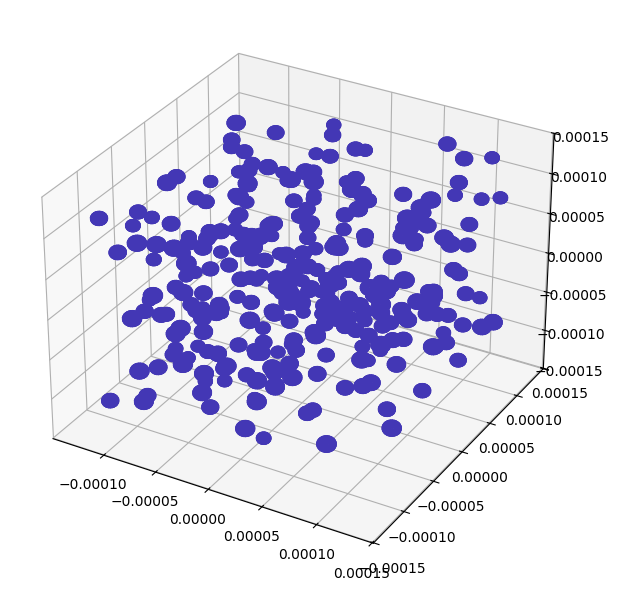

In [4]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100)
sd.detect()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/iSPN_to_iSPN_f1_mu2_a3_distdep/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 532/1331 (274 neurons)
Processing hyper voxel : 653/1331 (271 neurons)
Processing hyper voxel : 654/1331 (265 neurons)
Processing hyper voxel : 533/1331 (263 neurons)
Processing hyper voxel : 664/1331 (233 neurons)
Processing hyper voxel : 543/1331 (224 neurons)
Processing hyper voxel : 544/1331 (221 neurons)
Processing hyper voxel : 665/1331 (218 neurons)
Processing hyper voxel : 521/1331 (112 neurons)
Processing hyper voxel : 522/1331 (108 neurons)
Processing hyper voxel : 643/1331 (100 neurons)
Processing hyper voxel : 531/1331 (95 neurons)
Processing hyper voxel : 642/1331 (92 neurons)
Processing hyper voxel : 412/1331 (91 neurons)
Processing hyper voxel : 411/1331 (90 neurons)
Processing hyper voxel : 652/1331 (88 neurons)
Processing hyper voxel : 655/1331 (86 neurons)
Processi

In [6]:
from snudda.optimise.optimise_pruning import OptimisePruning
op = OptimisePruning(network_path=network_path)

In [7]:
op.merge_putative_synapses(force_merge=True)

Read 113726 out of total 113726 synapses


In [8]:
op.prune.connectivity_distributions

{(1,
  1,
  10): ({'f1': 1.0,
   'soft_max': None,
   'mu2': None,
   'a3': None,
   'dist_pruning': None,
   'cluster_pruning': False}, None)}

In [9]:
op.prune.type_id_lookup

{'iSPN': 1}

In [10]:
op.prune.hist_file["meta/connectivity_distributions"][()]

b'{"iSPN$$iSPN": {"GABA": {"conductance": [2.4e-10, 1e-10], "channel_parameters": {"mod_file": "tmGabaA"}, "cluster_size": 1, "cluster_spread": null, "pruning": {"f1": null, "soft_max": null, "mu2": null, "a3": null, "dist_pruning": null, "cluster_pruning": false}, "channel_model_id": 10, "lognormal_mu_sigma": [-22.230424900260093, 0.40010675493807013]}}}'

In [11]:
res = op.optimize(pre_type=pre_type, post_type=post_type, con_type=con_type, 
                  experimental_data=experimental_data, 
                  avg_num_synapses_per_pair=avg_num_synapses_per_pair,
                  extra_pruning_parameters=extra_pruning_parameters, 
                  workers=8, maxiter=1000, pop_size=pop_size, tol=0.00001, 
                  param_names=param_names, param_bounds="default")

/home/hjorth/HBP/Snudda/venv/lib/python3.13/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


numprocs=1
Worker iter: 100, fitness 15.753808784098318
Worker iter: 100, fitness 15.508567694059316
Worker iter: 100, fitness 15.478462818471652
Worker iter: 100, fitness 15.721702705405296
Worker iter: 100, fitness 15.47363094270992
Worker iter: 100, fitness 15.245088812742353
Worker iter: 100, fitness 15.613802304162403
Worker iter: 100, fitness 15.541517898430932
Worker iter: 200, fitness 15.084772437945812
Worker iter: 200, fitness 15.088890868400986
Worker iter: 200, fitness 15.100091958879306
Worker iter: 200, fitness 15.062489903355997
Worker iter: 200, fitness 15.08751055330121
Worker iter: 200, fitness 15.08541639046202
Worker iter: 200, fitness 15.102405610613493
Worker iter: 200, fitness 15.127553310299039
Worker iter: 300, fitness 15.009772435893737
Worker iter: 300, fitness 15.003846587573413
Worker iter: 300, fitness 14.996932363853489
Worker iter: 300, fitness 14.998432781738469
Worker iter: 300, fitness 15.006179968190757
Worker iter: 300, fitness 15.002973438197156
Wo

In [18]:
op.export_json("network-config-opt.json", append=True, res=res)

# Best parameter set

In [13]:
param_str = ""
for p_name, p_val in zip(param_names, res.x):
    param_str += f"{p_name} = {p_val:.4f}, "
    
if "distPruning" in extra_pruning_parameters:
   param_str += f" ({extra_pruning_parameters['distPruning']})"                                                  
                                                 
print(param_str)

f1 = 0.3105, mu2 = 1.6518, a3 = 0.9990,  (1-exp(-(0.4*d/60e-6)**2))


In [14]:
res

             message: Optimization terminated successfully.
             success: True
                 fun: 14.992007956417385
                   x: [ 3.105e-01  1.652e+00  9.990e-01]
                 nit: 75
                nfev: 3424
          population: [[ 3.105e-01  1.652e+00  9.990e-01]
                       [ 3.105e-01  1.652e+00  9.990e-01]
                       ...
                       [ 3.105e-01  1.652e+00  9.990e-01]
                       [ 3.105e-01  1.652e+00  9.990e-01]]
 population_energies: [ 1.499e+01  1.499e+01 ...  1.499e+01  1.499e+01]

In [15]:
import os
from snudda.analyse.analyse import SnuddaAnalyse
import glob

# Get the last file
# list_of_files = glob.glob(os.path.join(network_path, "temp", "network-synapses-*hdf5"))
# network_file = max(list_of_files, key=os.path.getctime)

network_file = os.path.join(network_path, "network-synapses.hdf5")

dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Creating figures directory networks/iSPN_to_iSPN_f1_mu2_a3_distdep/figures
Number of neurons: 300
Synapse row 0 - 0.0 % time: 0.003553417000148329 seconds
Created connection matrix 0.01720495800145727 seconds
Created gap junction connection matrix 0.0002071250000881264 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 22808, at 0
Created distance histogram (optimised) in 0.028866000000562053 seconds
Saving cache to networks/iSPN_to_iSPN_f1_mu2_a3_distdep/network-synapses.hdf5-cache


Plotting connection probability iSPN to iSPN (synapses)
Centering in None : Keeping 300/300
Counting connections
Requested: 10000000.0 calculated [89700.]
Num pairs outside plot range 0
P(d<5e-05) = 0.3205944798301486
P(d<0.0001) = 0.2052017855516079


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1443: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


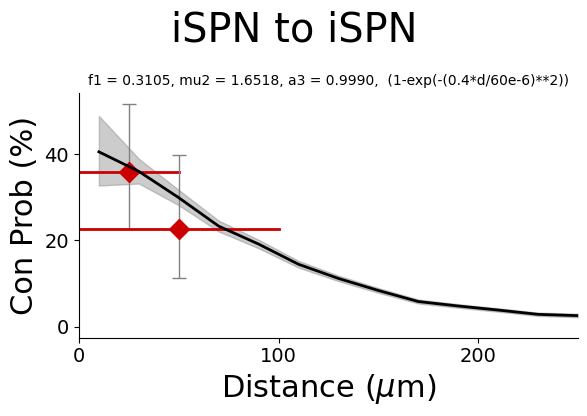

Wrote networks/iSPN_to_iSPN_f1_mu2_a3_distdep/figures/Network-distance-dependent-connection-probability-iSPN-to-iSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 300/300
Calculating max synapses
Calculating mean synapses
Plotting 8228 connections


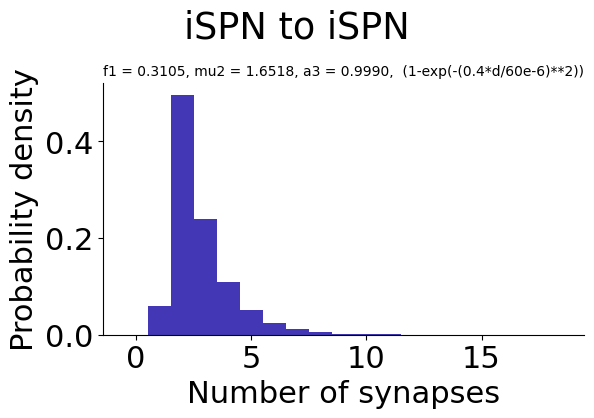

Wrote networks/iSPN_to_iSPN_f1_mu2_a3_distdep/figures/Network-number-of-synapses-from-iSPN-to-iSPN-per-cell.png


In [16]:
if pre_type == "dSPN" and post_type == "iSPN":
    sa.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "iSPN", sub_title=param_str)
elif pre_type == "dSPN" and post_type == "dSPN":
    sa.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "dSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "iSPN":
    sa.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "iSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "dSPN":
    sa.plot_connection_probability("iSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(13, 47), (10, 80)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "dSPN", sub_title=param_str)
elif pre_type == "FS" and post_type == "FS":
    sa.plot_connection_probability("FS", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(7, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "FS", sub_title=param_str)
elif pre_type == "FS" and post_type == "iSPN":
    sa.plot_connection_probability("FS", "iSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(6, 9), (21, 54), (27,77)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "iSPN", sub_title=param_str)
elif pre_type == "FS" and post_type == "dSPN":
    sa.plot_connection_probability("FS", "dSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(8, 9), (29, 48), (48,90)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "dSPN", sub_title=param_str)
    
elif pre_type == "FS" and post_type == "LTS":
    sa.plot_connection_probability("FS", "LTS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "LTS", sub_title=param_str)
elif pre_type == 'LTS' and post_type == "dSPN":
    sa.plot_connection_probability("LTS", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "dSPN", sub_title=param_str)
elif pre_type == 'LTS' and post_type == "iSPN":
    sa.plot_connection_probability("LTS", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "iSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "dSPN":
    sa.plot_connection_probability("ChIN", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "dSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "iSPN":
    sa.plot_connection_probability("ChIN", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "iSPN", sub_title=param_str)

# Missing pairwise experimental data...
    
elif pre_type == 'ChIN' and post_type == "FS":
    sa.plot_connection_probability("ChIN", "FS", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "FS", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "LTS":
    sa.plot_connection_probability("ChIN", "LTS", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "LTS", sub_title=param_str)

elif pre_type == 'LTS' and post_type == "ChIN":
    sa.plot_connection_probability("LTS", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "ChIN", sub_title=param_str)

    
elif pre_type == 'dSPN' and post_type == "ChIN":
    sa.plot_connection_probability("dSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "ChIN", sub_title=param_str)
elif pre_type == 'iSPN' and post_type == "ChIN":
    sa.plot_connection_probability("iSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "ChIN", sub_title=param_str)

    

